# Problem House pricing piecewise linear regression

The goal of this notebook is to improve the prediction performance of the Bayesian linear regression model in the notebook `House_dataset_regression` by using a piecewise linear regression model (4 linear models).

In particular, we will use a Gaussian Mixture Model clustering algorithm to cluster the inputs in 4 clusters using the latitude and longitude as clustering variables. The intuition is that, since the house price strongly depends on the location of the house (given similar features), this should help us to improve the performance.

Your goal is to implement a different Bayesian linear regression model for each group of clustered houses and then:
1. perform posterior predictive checks separately for each clustered training dataset
2. compute the MAE separately for each clustered test set
3. perform  posterior predictive checks for  the training data (all together) by simply joining the 4 different predictions
4. compute the MAE for all the test set
5. perform  posterior predictive checks for  the test data (all together) by simply joining the 4 different predictions

You should obtain the following results for the MAE:

    Size Cluster0 258 , MAE Cluster0= 203964.66881499
    Size Cluster1 85 , MAE Cluster1= 216034.99530180823
    Size Cluster2 81 , MAE Cluster2= 202778.29337653224
    Size Cluster3 66 , MAE Cluster3= 144075.32799975947
    MAE overall= 197795.6582987844


The following code loads the data and split the dataset in four parts.

Note that using GMM for clustering is not optimal because it does not consider the other inputs and the value of the output. There are much better ways to implement piecewise linear models that can learn how to cluster the data in an optimal way for the regression problem (similar to regression trees). 
If you are interested in reading more about that, this gives you an overview 
http://hedibert.org/wp-content/uploads/2018/06/bayesian-CART.pdf (optional)

### load dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import arviz as az
from sklearn.preprocessing import StandardScaler

dftrain = pd.read_csv("../datasets/house_price_csv/train.csv",index_col='ad_id')
dftest  = pd.read_csv( "../datasets/house_price_csv/test.csv",index_col='ad_id')
dfyte=pd.read_csv("../datasets/house_price_csv/true_price.csv")
ytest_price=dfyte.Expected.values

#select some features columns just for the baseline model
df_subset_train = dftrain[['bathrooms','beds','surface','latitude','longitude','price']].dropna(axis=0)
df_subset_test  =  dftest[['bathrooms','beds','surface','latitude','longitude']]

X = df_subset_train.iloc[:,0:-1].values #input columns
y = df_subset_train.iloc[:,-1].values.reshape(-1,1)   #output column, price
#test set
Xtest = df_subset_test.iloc[:,0:].values #input columns

#Cleaning
ind=np.where((X[:,0]==0) & (X[:,1]==0))[0]
X=np.delete(X,ind,axis=0)#0 bathrooms, 0 bedrooms
y=np.delete(y,ind,axis=0)#0 bathrooms, 0 bedrooms

ind=np.where((X[:,2]==0))[0]
X=np.delete(X,ind,axis=0)#0 surface
y=np.delete(y,ind,axis=0)#0 surface

#removeing possible outliers

IND=np.array([  42,  166,  326,  537, 1201]) #np.unique(np.hstack(IND),axis=0)
X=np.delete(X,IND,0)
y=np.delete(y,IND,0)

#Cleaning
ind=np.where((Xtest[:,0]==0) & (Xtest[:,1]==0))[0]
Xtest=np.delete(Xtest,ind,axis=0)#0 bathrooms, 0 bedrooms
ytest_price=np.delete(ytest_price,ind,axis=0)#0 bathrooms, 0 bedrooms

X=np.hstack([X,X[:,[2]]**2])
xscaler = StandardScaler().fit(X)
Xn=xscaler.transform(X)
Xtest=np.hstack([Xtest,Xtest[:,[2]]**2])
Xtestn=xscaler.transform(Xtest)

yscaler = StandardScaler().fit(y)
yn=yscaler.transform(y)

## Clustering in 4 parts

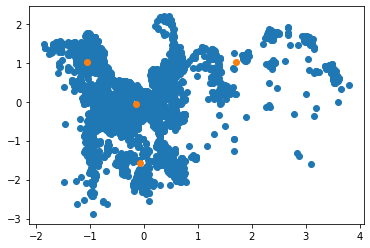

In [2]:
# training gaussian mixture model 
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4)
#we cluster by lat and long
ind=[3,4]
XX=np.vstack([Xn[:,ind],Xtestn[:,ind]])
XX=np.vstack([Xn[:,ind],Xtestn[:,ind]])
gmm.fit(XX)
plt.scatter(XX[:,0],XX[:,1])
#plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1])
plt.scatter(gmm.means_[:,0],gmm.means_[:,1])

clusters_ind = gmm.predict(Xn[:,ind])
clusters_ind_te = gmm.predict(Xtestn[:,ind])

Xn0=Xn[clusters_ind==0,:]
Xtestn0=Xtestn[clusters_ind_te==0,:]
ylog0=np.log(y[clusters_ind==0,:])
yscaler0 = StandardScaler().fit(ylog0)
yn0=yscaler0.transform(ylog0)


Xn1=Xn[clusters_ind==1,:]
Xtestn1=Xtestn[clusters_ind_te==1,:]
ylog1=np.log(y[clusters_ind==1,:])
yscaler1 = StandardScaler().fit(ylog1)
yn1=yscaler1.transform(ylog1)

Xn2=Xn[clusters_ind==2,:]
Xtestn2=Xtestn[clusters_ind_te==2,:]
ylog2=np.log(y[clusters_ind==2,:])
yscaler2 = StandardScaler().fit(ylog2)
yn2=yscaler2.transform(ylog2)

Xn3=Xn[clusters_ind==3,:]
Xtestn3=Xtestn[clusters_ind_te==3,:]
ylog3=np.log(y[clusters_ind==3,:])
yscaler3 = StandardScaler().fit(ylog3)
yn3=yscaler3.transform(ylog3)

## Linear regression model

For each cluster, consider the following linear regression model

$$
price = \alpha + \beta_1 \text{bathrooms}+ \beta_2 \text{beds} + \beta_3 \text{surface} + \beta_4 \text{latitude} + \beta_5 \text{longitude} + \beta_6 \text{surface}^2 + noise
$$

Note that we have added $ \text{surface}^2$ to account for the nonlinear dependence of the the price on the house area (surface). We have  also assumed that there is (observation) noise in our model. We assume that the noise is Gaussian with zero mean and variance $\sigma^2$.

$$
noise \sim Normal(0,\sigma^2)
$$
